## Предобработка данных и логистическая регрессия для задачи бинарной классификации

Автор задания: Захаров Егор

Редактор: Надежда Чиркова
    
Задание присылать на почту группы с темой [ИАД16, HW5] Фамилия Имя

В задании вам будет предложено ознакомиться с основными техниками предобработки данных, а также применить их для обучения модели логистической регрессии.

Для выполнения задания требуется Python версии 2.7, а также актуальные версии библиотек:
- NumPy: 1.10.4 и выше
- Pandas: 0.17.1 и выше
- Scikit-learn: 0.17 и выше

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Описание датасета

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам на гранты, которые были поданы в университете Мельбурна в период с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

Выделим из датасета целевую переменную Grant.Status и обозначим её за y
Теперь X обозначает обучающую выборку, y - ответы на ней

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Теория по логистической регрессии

После осознания того, какую именно задачу требуется решить на этих данных, следующим шагом при реальном анализе был бы подбор подходящего метода. В данном задании выбор метода было произведён за вас, это логистическая регрессия. Кратко напомним вам используемую модель.

Логистическая регрессия предсказывает вероятности принадлежности объекта к каждому классу. Сумма ответов логистической регрессии на одном объекте для всех классов равна единице.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, \theta), $$

где:
- $\pi_{ik}$ - вероятность принадлежности объекта $x_i$ из выборки $X$ к классу $k$
- $\theta$ - внутренние параметры алгоритма, которые настраиваются в процессе обучения, в случае логистической регрессии - $w, b$

Из этого свойства модели в случае бинарной классификации требуется вычислить лишь вероятность принадлежности объекта к одному из классов (вторая вычисляется из условия нормировки вероятностей). Эта вероятность вычисляется, используя логистическую функцию:

$$ P\,(y_i = 1 \mid x_i, \theta) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Параметры $w$ и $b$ находятся, как решения следующей задачи оптимизации (указаны функционалы с L1 и L2 регуляризацией, с которыми вы познакомились в предыдущих заданиях):

L2-regularization:

$$ Q(X, y, \theta) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y, \theta) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - это стандартный гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные.

## Деление выборки

In [4]:
data.shape

(6000, 39)

Поделим выборку на обучение и контроль. Выберем 4000 случайынх объектов в обучение и остальное - в контроль.

In [78]:
msk = np.random.permutation(np.arange(data.shape[0])) < 4000
data_train = data[msk]
data_test = data[~msk]
y_train = y[msk]
y_test = y[~msk]

In [79]:
data_train.shape, data_test.shape, y_train.shape, y_test.shape

((4000, 39), (2000, 39), (4000,), (2000,))

## Предобработка данных

В данных есть пропуски, кроме того, некоторые признаки категориальные.  Нужно закодировать категориальные признаки и удалить и интерпретировать пропущенные значения.

In [65]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть как числовые, так и категориальные признаки. Получим списки их названий:

In [66]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

Попробуем удалить объекты с пропусками:

In [67]:
data.dropna().shape

(213, 39)

Видно, что тогда мы выбросим почти все данные, и такой метод решения не сработает.

Пропущенные значения можно так же интерпретировать, для этого существует несколько способов, они различаются для категориальных и вещественных признаков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет)
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака на датасете)

Для категориальных:
- интерпретировать пропущенное значение, как ещё одну категорию (данный способ является самым естественным, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется)

<font color="green">Задание!</font>

1. Создайте копию обучающей и тестовой выборок. Заполните пропущенные вещественные значения в них нулями или средними по столбцам (в одной матрице одним споосбом, во второй - другим). Средние нужно вычислять только по обучающей выборке!
2. Все категориальные признаки преобразуйте в строки, пропущенные значения требуется также преобразовать в какие-либо строки, которые не являются категориями (например, 'nan'). Используйте метод датафрейма .astype
3. Используйте DictVectorizer, чтобы закодировать категориальные признаки. Помните, что как и во втором домашнем задании, нужно подавать на вход DictVectorizer объединенную выборку, чтобы и в обучении, и в контроле одни и те же категории перешли в одни и те же признаки.

За циклы по объектам будем снижать баллы! Только векторизованные numpy-операции, это легко! Цикл по признакам, так и быть, можно.

In [72]:
# Importing DictVectorizer
from sklearn.feature_extraction import DictVectorizer

In [73]:
# Replacing nans in train and test samples with mean values
mean = data_train[numeric_cols].mean().copy()

train_m_numerical = data_train[numeric_cols].fillna(mean).copy()
test_m_numerical = data_test[numeric_cols].fillna(mean).copy()

# Replacing nans in train and test samples with zero values
train_z_numerical = data_train[numeric_cols].fillna(0).copy()
test_z_numerical = data_test[numeric_cols].fillna(0).copy()

# Converting categorical features into strings, updating nans
train_cat = data_train[categorical_cols].astype(str).fillna('nan')
test_cat = data_test[categorical_cols].astype(str).fillna('nan')

# Using DictVectorizer to encode categorical features
dv = DictVectorizer(sparse = False)
data_cat = dv.fit_transform(pd.concat([train_cat, test_cat]).T.to_dict().values())

# Encoding test and train features

train_cat = dv.transform(train_cat.T.to_dict().values())
test_cat = dv.transform(test_cat.T.to_dict().values())

# Splitting back
train_cat = data_cat[:4000]
test_cat = data_cat[4000:]

# Putting all together
X_train_m = np.hstack((train_m_numerical, train_cat))
X_test_m = np.hstack((test_m_numerical, test_cat))

X_train_z = np.hstack((train_z_numerical, train_cat))
X_test_z = np.hstack((test_z_numerical, test_cat))


## Обучение логистической регрессии

Обучим на полученных регрессию, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator - обучающий алгоритм, для которого будет производиться подбор параметров
- param_grid - словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения - набор параметров для перебора

Данный класс выполняет кросс-валидацию обучающей выборки для каждого набора параметров и находит те, на которых алгоритм работает лучше всего. Этот метод позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring - функционал качества, максимум которого ищется кросс валидацией, по умолчанию используется функция score() класса esimator
- n_jobs - позволяет ускорить кросс-валидацию, выполняя её параллельно, число определяет количество одновременно запущенных задач
- cv - количество фолдов, на которые разбивается выборка при кросс-валидации

После инициализации класса GridSearchCV, процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения предсказаний можно пользоваться функцией

    optimizer.predict(X)
    
для меток или

    optimizer.predict_proba(X)
    
для вероятностей (в случае использования логистической регрессии).
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ - лучший алгоритм
- best\_params\_ - лучший набор параметров

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
где penalty принимает либо значение 'l2', либо 'l1'. По умолчанию устанавливается значение 'l2', и везде в задании, если об этом не оговорено особо, предполагается использование логистической регрессии с L2-регуляризацией.

<font color="green">Задание!</font>

2. Обучите логистическую регрессию два раза: сначала на обучающей выборке с нулями вместо пропусков, затем на обучающей выборке со средними вместо пропусков. Подберите параметры из заданной в следующей ячейке сетки param_grid по методу кросс-валидации с числом фолдов cv=3. В качестве оптимизируемой функции используйте заданную по умолчанию. Обучение производим только на обучающих выборках!
3. Постройте два графика оценок точности +- их стандратного отклонения в зависимости от гиперпараметра и убедитесь, что вы действительно нашли её максимум. Также обратите внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv). _Комментарий. Стандартное отклонение, как и среднее, нужно считать по массиву из 3-х чисел, возвращаемому для каждого значения гиперпараметра кросс-валидатором._
4. Получите две метрики качества AUC ROC на тестовой выборке и сравните их между собой. Какой способ заполнения пропущенных вещественных значений работает лучше? __В дальнейшем для выполнения задания используйте ту обучающую выборку из двух, которая даёт лучшее качество на тесте__.

Информация для интересующихся: вообще говоря, не вполне логично оптимизировать на кросс-валидации заданный по умолчанию в классе логистической регрессии функционал accuracy, а измерять на тесте AUC ROC, но это сделано для ускорения работы процесса кросс-валидации. Будем здорово, если вы также сделаете кросс-валидацию с метрикой AUC_ROC.

In [74]:
def create_plot(grid_scores, plot_name):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.plot(scores[:,0], scores[:,1])
    plt.title(plot_name)
    plt.xlabel('Parametr values')
    plt.ylabel('Sandard deviation')
    plt.show()

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

estimator = LogisticRegression()
optimizer = GridSearchCV(estimator, param_grid, cv = cv, n_jobs = -1)

Best params mean: 0.01


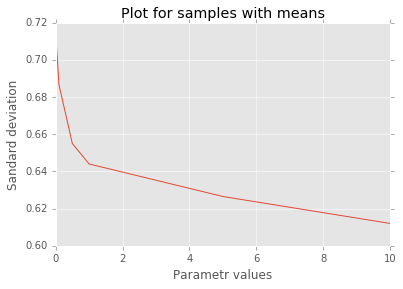

In [76]:
# Working with samples with mean values.

# Fitting optimizer
fitted_m = optimizer.fit(X_train_m, y_train)
print('Best params mean:', optimizer.best_params_['C'])

# Predicting on test samples
predict_m = optimizer.predict(X_test_m)

# Getting AUC ROC score
auc_m = roc_auc_score(y_test, predict_m)

# Creating plot
create_plot(optimizer.grid_scores_, 'Plot for samples with means')

Best params zeros: 0.01


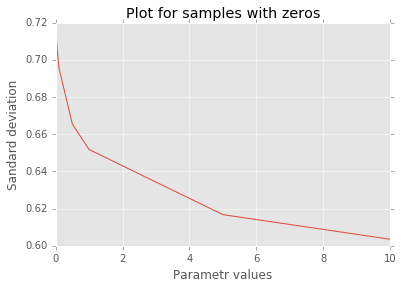

In [51]:
# Working with samples with mean values.

# Fitting optimizer
fitted_m = optimizer.fit(X_train_z, y_train)
print('Best params zeros:', optimizer.best_params_['C'])

# Predicting on test samples
predict_z = optimizer.predict(X_test_z)

# Getting AUC ROC score
auc_z = roc_auc_score(y_test, predict_z)

# Creating plot
create_plot(optimizer.grid_scores_, 'Plot for samples with zeros')

In [52]:
print('AUC ROC for zeros version = ', auc_z)
print('AUC ROC for mean version = ', auc_m)

AUC ROC for zeros version =  0.704641637399
AUC ROC for mean version =  0.699873653727


## Масштабирование вещественных признаков.

Попробуем как-то улучшить качество классификации. Для этого посмотрим на сами данные:

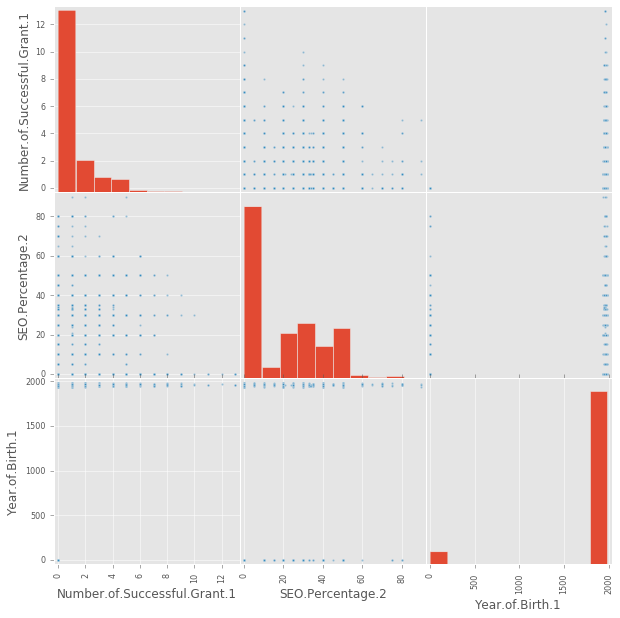

In [55]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(pd.DataFrame(train_z_numerical, columns=numeric_cols))
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях всегда рекомендуется делать стандартизацию (масштабирование) признаков, для того чтобы они меньше отличались друг друга по модулю, но при этом не нарушались никакие другие свойства признакового пространства. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретабельность, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

<font color="green">Задание!</font>

1. Примените масштабирование вещественных признаков для обучающей и тестовой выборок, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)
2. Сохраните ответ в переменные X_train_real_scaled и X_test_real_scaled соответственно

In [33]:
from sklearn.preprocessing import StandardScaler

# Scaling our numerical features
scaler = StandardScaler()

X_train_real_scaled = scaler.fit_transform(train_z_numerical)
X_test_real_scaled = scaler.transform(test_z_numerical)

## Сравнение признаковых пространств.

Построим такие же графики для преобразованных данных:

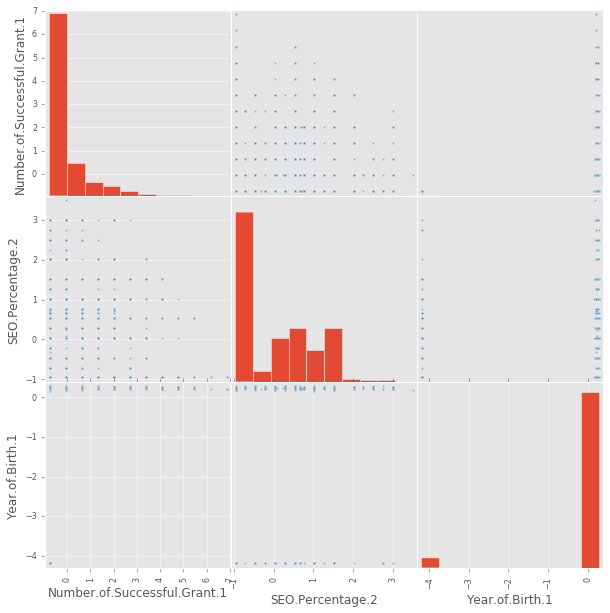

In [34]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков, как и их scatter-plots, выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне, тем самым повышая интерпретабельность результатов, а также лучше сочетаясь с идеологией регуляризации.

<font color="green">Задание!</font>

1. Обучите ещё раз регрессию и найдите гиперпараметр методом кросс-валидации на новых признаках.
3. Получите значение ROC AUC на тестовой выборке, сравните с лучшим результатом, полученными ранее.

In [20]:
# Creating new train and test samples based on scaled parameters
X_train_z_scaled = np.hstack((X_train_real_scaled, train_cat))
X_test_z_scaled = np.hstack((X_test_real_scaled, test_cat))

# Fitting with new data
optimizerScaled = GridSearchCV(estimator, param_grid, cv = cv, n_jobs = -1)

optimizerScaled.fit(X_train_z_scaled, y_train)

# Predicting on test scaled data
predict_z_scaled = optimizerScaled.predict(X_test_z_scaled)

# Calulating AUC ROC value
auc_z_scaled = roc_auc_score(y_test, predict_z_scaled)

print('AUC ROC for scaled zeros version = ', auc_z_scaled)

AUC ROC for scaled zeros version =  0.700168196318


## Балансировка классов.

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам. Если классы не сбалансированы, то есть соотношение числа объектов одного класса к числу объектов другого класса сильно больше или меньше единицы, то класс, объектов которого больше, называют мажоритарным, а другой - миноритарным.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [21]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2186
1814


Видно, что нет.

Исправить ситуацию можно разными способами, мы рассмотрим два:
- давать объектам миноритарного класса больший вес при обучении классификатора
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется

<font color="green">Задание!</font>

1. Обучите логистическую регрессию и найдите гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированной обучающей выборке, полученной в предыдущем задании.
2. Получите метрику ROC AUC на тестовой выборке.
3. Сбалансируйте выборку, досэмплировав в неё объекты из меньшего класса. Найдите количество объектов миноритарного класса, затем сгенерируйте массив случайных индексов этих объектов с помощью функции np.random.randint, затем выделите объекты миноритарного класса, которые нужно добавить, с помощью функции
        X_train_to_add = X_train[y_train.as_matrix() == 1, :][indices_to_add,:]
   После этого добавьте эти объекты в начало или конец обучающей выборки. Дополните соответствующим образом вектор ответов.
4. Получите метрику ROC AUC на тестовой выборке, сравните с предыдущим результатом.

In [22]:
# place your code here

Вы разобрались с основными этапами предобработки данных для линейных классификаторов.
Напомним основные этапы:
- обработка пропущенных значений
- обработка категориальных признаков
- балансировка классов
- масштабирование

Эти действия с данными рекомендуется проводить всякий раз, когда вы планируете использовать линейные методы. Рекомендация по выполнению многих из этих пунктов справедлива и для других методов машинного обучения.